In [1]:
from header import *
from tqdm import tqdm
from sampytools.list_utils import generate_comma_separated_text
from utils.analytics import ewma_volatility

# I want to compute mean return and volatilities of TOPIX Core30 stocks
eqsmdf = pd.read_sql("SELECT * FROM eq_sec_master WHERE new_index_series_code_en='TOPIX Core30'", engine)
logging.info(f"Fetched eq sec_master : {len(eqsmdf)}")

crdf = pd.read_sql(
    f"SELECT * FROM eq_returns WHERE ticker in ({generate_comma_separated_text(eqsmdf.ticker.unique())})", engine)
logging.info(f"Fetched {len(crdf):,} daily returns")
crdf["adate"] = pd.to_datetime(crdf["adate"])

# we will use daily returns since 2023 to compute mean returns and volatilities
subcrdf = crdf[crdf["adate"] >= "2023"][["adate", "ticker", "daily_ret"]]

tickers = list(subcrdf.ticker.unique())
eqmvdf = pd.DataFrame({"ticker": tickers, "eret": 0.0, "vol": 0.0})

with tqdm(total=len(tickers)) as pbar:
    for idx, row in eqmvdf.iterrows():
        ticker = row["ticker"]
        df = subcrdf[subcrdf["ticker"] == ticker]
        eret = df["daily_ret"].mean()
        vols = ewma_volatility(df["daily_ret"], decay_factor=0.94)
        eqvol = vols.iloc[-1]
        eqmvdf.loc[idx, "eret"] = eret
        eqmvdf.loc[idx, "vol"] = eqvol
        pbar.set_description(f"{ticker} eret : {eret:.2}, vol : {eqvol:.2}")
        pbar.update(1)


INFO:root:Fetched eq sec_master : 30
INFO:root:Fetched 41,506 daily returns
9984.T eret : 0.0013, vol : 0.027: 100%|██████████| 29/29 [00:00<00:00, 299.05it/s]  


In [8]:
# show all table names
meta.tables.keys()

dict_keys(['eq_prices', 'eq_company_profile', 'eq_returns', 'eq_sec_master'])

In [ ]:
# let's load company profiles
profdf=pd.read_sql("SELECT * FROM eq_company_profile",engine)
profdf.head()

In [ ]:
# load sec_master
smdf=pd.read_sql("SELECT * FROM eq_sec_master",engine)
smdf.head()

,id,ticker,weight_date,desc_en,desc_jp,industry_en,industry_jp,new_index_series_code_en,new_index_series_code_jp,component_weight
0,1,1301.T,2020-03-31,"KYOKUYO CO.,LTD.",極洋,"Fishery, Agriculture and Forestry",水産・農林業,TOPIX Small 2,TOPIX Small 2,0.000061
1,2,1332.T,2020-03-31,"Nippon Suisan Kaisha,Ltd.",日水,"Fishery, Agriculture and Forestry",水産・農林業,TOPIX Mid400,TOPIX Mid400,0.000329
2,3,1333.T,2020-03-31,Maruha Nichiro Corporation,マルハニチロ,"Fishery, Agriculture and Forestry",水産・農林業,TOPIX Mid400,TOPIX Mid400,0.000224
3,4,1352.T,2020-03-31,HOHSUI CORPORATION,ホウスイ,Wholesale Trade,卸売業,TOPIX Small 2,TOPIX Small 2,0.000003
4,5,1376.T,2020-03-31,"KANEKO SEEDS CO.,LTD.",カネコ種苗,"Fishery, Agriculture and Forestry",水産・農林業,TOPIX Small 2,TOPIX Small 2,0.000028


In [10]:
smdf.component_weight.sum()

np.float64(1.000001)

In [11]:
# join eqmvdf which has mean returns and daily volatilities with company name, industry and weight in TOPIX index
mrgmvdf=pd.merge(left=eqmvdf,right=smdf[["ticker","desc_en","industry_en","component_weight"]],on="ticker",how="left")
logging.info(f"eq mean returns and volatilities length after merge : {len(mrgmvdf)}")

INFO:root:eq mean returns and volatilities length after merge : 29


In [12]:
mrgmvdf.head()

,ticker,eret,vol,desc_en,industry_en,component_weight
0,2914.T,0.001083,0.013774,JAPAN TOBACCO INC.,Foods,0.005857
1,3382.T,0.000759,0.031072,"Seven & I Holdings Co.,Ltd.",Retail Trade,0.006977
2,4063.T,0.001431,0.017989,"Shin-Etsu Chemical Co.,Ltd.",Chemicals,0.009137
3,4452.T,0.000480,0.012713,Kao Corporation,Chemicals,0.010705
4,4502.T,0.000120,0.010335,Takeda Pharmaceutical Company Limited,Pharmaceutical,0.013936


In [14]:
# save data as list of JSON objects
import pathlib
folder=pathlib.Path.cwd()/"datasets"
mrgmvdf.to_json(folder/"topix_29core_mean_var.json",orient="records",index=False)

In [20]:
from sampytools.datetime_utils import to_yyyymmdd

print(f"Daily returns are from {subcrdf.adate.min()} to {subcrdf.adate.max()}")


Daily returns are from 2023-01-04 00:00:00 to 2024-11-19 00:00:00


<Axes: xlabel='Risk', ylabel='Mean return'>

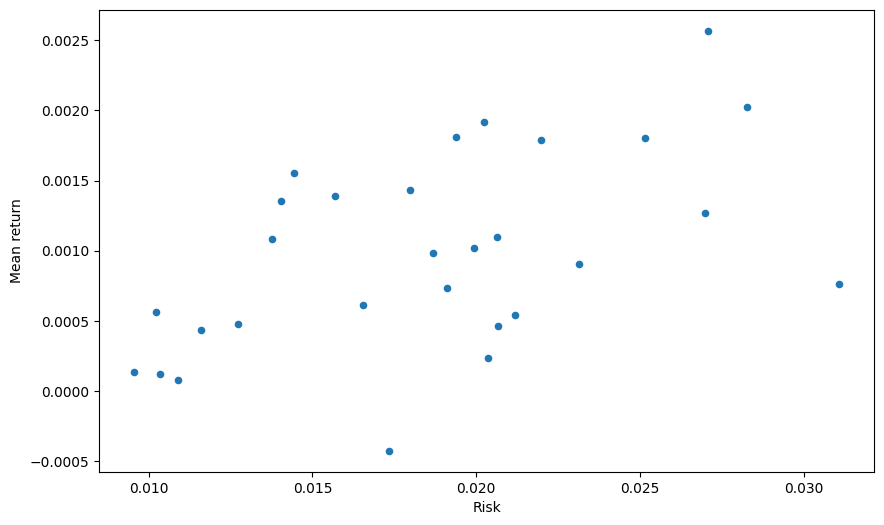

In [ ]:
import matplotlib.pyplot as plt

eqmvdf.plot(kind="scatter",x="vol",y="eret",figsize=(10,6),xlabel="Risk", ylabel="Mean return")